# 16-720 HW6: Photometric Stereo

#### **For each question please refer to the handout for more details.**

Programming questions begin at **Q1**. **Remember to run all cells** and save the notebook to your local machine as a pdf for gradescope submission.

# Collaborators
**List your collaborators for all questions here**:


---

# Utils and Imports

Importing all necessary libraries.


In [9]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2xyz
import warnings
from scipy.ndimage import gaussian_filter
from matplotlib import cm
from skimage.io import imread
from scipy.sparse import kron as spkron
from scipy.sparse import eye as speye
from scipy.sparse.linalg import lsqr as splsqr
import os
import shutil


Downloading the data

In [11]:
if os.path.exists('./content/data'):
  shutil.rmtree('./content/data')

os.mkdir('./content/data')
!wget 'https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0' -O ./content/data/data.zip
!unzip "./content/data/data.zip" -d "./content/"
os.system("rm ./content/data/data.zip")
data_dir = './content/data/'


--2024-04-27 23:02:14--  https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0
Resolving docs.google.com (docs.google.com)... 142.251.167.102, 142.251.167.101, 142.251.167.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.167.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download [following]
--2024-04-27 23:02:14--  https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.80.1, 2607:f8b0:4006:80d::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.80.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6210854 (5.9M) [application/octet-stream]
Saving to: ‘./content/data/data.zip’

./content/data/data 100%[===================>]   5.92M  4.

Utils Functions.

In [12]:
def integrateFrankot(zx, zy, pad = 512):

    """
    Question 1 (j)

    Implement the Frankot-Chellappa algorithm for enforcing integrability
    and normal integration

    Parameters
    ----------
    zx : numpy.ndarray
        The image of derivatives of the depth along the x image dimension

    zy : tuple
        The image of derivatives of the depth along the y image dimension

    pad : float
        The size of the full FFT used for the reconstruction

    Returns
    ----------
    z: numpy.ndarray
        The image, of the same size as the derivatives, of estimated depths
        at each point

    """

    # Raise error if the shapes of the gradients don't match
    if not zx.shape == zy.shape:
        raise ValueError('Sizes of both gradients must match!')

    # Pad the array FFT with a size we specify
    h, w = 512, 512

    # Fourier transform of gradients for projection
    Zx = np.fft.fftshift(np.fft.fft2(zx, (h, w)))
    Zy = np.fft.fftshift(np.fft.fft2(zy, (h, w)))
    j = 1j

    # Frequency grid
    [wx, wy] = np.meshgrid(np.linspace(-np.pi, np.pi, w),
                           np.linspace(-np.pi, np.pi, h))
    absFreq = wx**2 + wy**2

    # Perform the actual projection
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        z = (-j*wx*Zx-j*wy*Zy)/absFreq

    # Set (undefined) mean value of the surface depth to 0
    z[0, 0] = 0.
    z = np.fft.ifftshift(z)

    # Invert the Fourier transform for the depth
    z = np.real(np.fft.ifft2(z))
    z = z[:zx.shape[0], :zx.shape[1]]

    return z


def enforceIntegrability(N, s, sig = 3):

    """
    Question 2 (e)

    Find a transform Q that makes the normals integrable and transform them
    by it

    Parameters
    ----------
    N : numpy.ndarray
        The 3 x P matrix of (possibly) non-integrable normals

    s : tuple
        Image shape

    Returns
    -------
    Nt : numpy.ndarray
        The 3 x P matrix of transformed, integrable normals
    """

    N1 = N[0, :].reshape(s)
    N2 = N[1, :].reshape(s)
    N3 = N[2, :].reshape(s)

    N1y, N1x = np.gradient(gaussian_filter(N1, sig), edge_order = 2)
    N2y, N2x = np.gradient(gaussian_filter(N2, sig), edge_order = 2)
    N3y, N3x = np.gradient(gaussian_filter(N3, sig), edge_order = 2)

    A1 = N1*N2x-N2*N1x
    A2 = N1*N3x-N3*N1x
    A3 = N2*N3x-N3*N2x
    A4 = N2*N1y-N1*N2y
    A5 = N3*N1y-N1*N3y
    A6 = N3*N2y-N2*N3y

    A = np.hstack((A1.reshape(-1, 1),
                   A2.reshape(-1, 1),
                   A3.reshape(-1, 1),
                   A4.reshape(-1, 1),
                   A5.reshape(-1, 1),
                   A6.reshape(-1, 1)))

    AtA = A.T.dot(A)
    W, V = np.linalg.eig(AtA)
    h = V[:, np.argmin(np.abs(W))]

    delta = np.asarray([[-h[2],  h[5], 1],
                        [ h[1], -h[4], 0],
                        [-h[0],  h[3], 0]])
    Nt = np.linalg.inv(delta).dot(N)

    return Nt

def plotSurface(surface, suffix=''):

    """
    Plot the depth map as a surface

    Parameters
    ----------
    surface : numpy.ndarray
        The depth map to be plotted

    suffix: str
        suffix for save file

    Returns
    -------
        None

    """
    x, y = np.meshgrid(np.arange(surface.shape[1]),
                       np.arange(surface.shape[0]))
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, -surface, cmap = cm.coolwarm,
                           linewidth = 0, antialiased = False)
    ax.view_init(elev = 60., azim = 75.)
    plt.savefig(f'faceCalibrated{suffix}.png')
    plt.show()

def loadData(path = "../data/"):

    """
    Question 1 (c)

    Load data from the path given. The images are stored as input_n.tif
    for n = {1...7}. The source lighting directions are stored in
    sources.mat.

    Paramters
    ---------
    path: str
        Path of the data directory

    Returns
    -------
    I : numpy.ndarray
        The 7 x P matrix of vectorized images

    L : numpy.ndarray
        The 3 x 7 matrix of lighting directions

    s: tuple
        Image shape

    """
    I = None
    L = None
    s = None

    L = np.load(path + 'sources.npy').T

    im = imread(path + 'input_1.tif')
    P = im[:, :, 0].size
    s = im[:, :, 0].shape

    I = np.zeros((7, P))
    for i in range(1, 8):
        im = imread(path + 'input_' + str(i) + '.tif')
        im = rgb2xyz(im)[:, :, 1]
        I[i-1, :] = im.reshape(-1,)

    return I, L, s

def displayAlbedosNormals(albedos, normals, s):

    """
    Question 1 (e)

    From the estimated pseudonormals, display the albedo and normal maps

    Please make sure to use the `coolwarm` colormap for the albedo image
    and the `rainbow` colormap for the normals.

    Parameters
    ----------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    -------
    albedoIm : numpy.ndarray
        Albedo image of shape s

    normalIm : numpy.ndarray
        Normals reshaped as an s x 3 image

    """
    albedoIm = None
    normalIm = None

    albedoIm = albedos.reshape(s)
    normalIm = (normals.T.reshape((s[0], s[1], 3))+1)/2

    plt.figure()
    plt.imshow(albedoIm, cmap = 'gray')

    plt.figure()
    plt.imshow(normalIm, cmap = 'rainbow')

    plt.show()

    return albedoIm, normalIm

# Q1: Calibrated photometric stereo (75 points)


### Q 1 (a): Understanding n-dot-l lighting (5 points)

---

YOUR ANSWER HERE...

---


### Q 1 (b): Rendering the n-dot-l lighting (10 points)

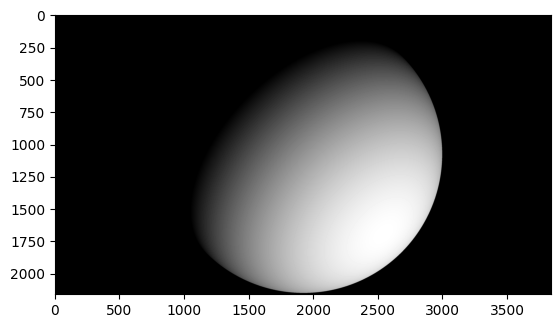

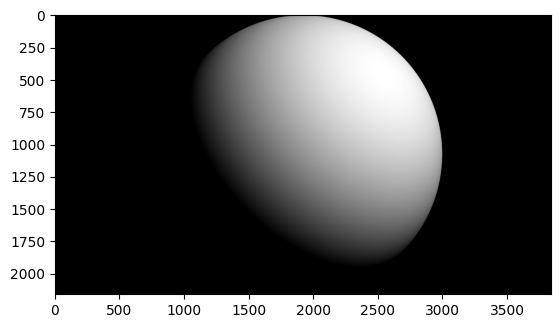

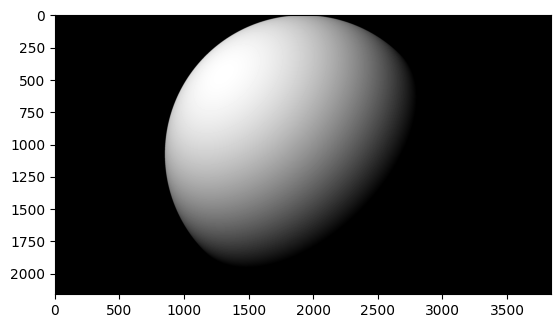

In [77]:
def renderNDotLSphere(center, rad, light, pxSize, res):

    """
    Question 1 (b)

    Render a hemispherical bowl with a given center and radius. Assume that
    the hollow end of the bowl faces in the positive z direction, and the
    camera looks towards the hollow end in the negative z direction. The
    camera's sensor axes are aligned with the x- and y-axes.

    Parameters
    ----------
    center : numpy.ndarray
        The center of the hemispherical bowl in an array of size (3,)

    rad : float
        The radius of the bowl

    light : numpy.ndarray
        The direction of incoming light

    pxSize : float
        Pixel size

    res : numpy.ndarray
        The resolution of the camera frame

    Returns
    -------
    image : numpy.ndarray
        The rendered image of the hemispherical bowl
    """

    [X, Y] = np.meshgrid(np.arange(res[0]), np.arange(res[1]))
    X = (X - res[0]/2) * pxSize*1.e-4
    Y = (Y - res[1]/2) * pxSize*1.e-4
    Z = np.sqrt(rad**2+0j-X**2-Y**2)
    X[np.real(Z) == 0] = 0
    Y[np.real(Z) == 0] = 0
    Z = np.real(Z)
    Z[np.isnan(Z)] = 0

    image = None
    ### YOUR CODE HERE
    # Calculate normals for the hemisphere
    
    # normals = np.stack((X, Y, Z), axis=-1)
    # normals /= np.linalg.norm(normals, axis=-1, keepdims=True)

    # # Mask out the points that don't belong to the hemisphere
    # mask = Z <= 0
    # normals[mask] = 0

    # # Compute the dot product with the light source
    # dot_product = np.einsum('ijk,k->ij', normals, light)
    # dot_product = np.clip(dot_product, 0, 1)  # Clamp values to the range [0, 1]

    # # Mask out the background
    # image = np.where(mask, 0, dot_product)

    image=(X*light[0]+Y*light[1]+Z*light[2])/rad
    image[image<0]=0

 

    
    ### END YOUR CODE

    return image

# Part 1(b)
radius = 0.75 # cm
center = np.asarray([0, 0, 0]) # cm
pxSize = 7 # um
res = (3840, 2160)

light = np.asarray([1, 1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-a.png', image, cmap = 'gray')

light = np.asarray([1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-b.png', image, cmap = 'gray')

light = np.asarray([-1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-c.png', image, cmap = 'gray')

I, L, s = loadData(data_dir)


### Q 1 (c): Initials (10 points)


In [15]:
### YOUR CODE HERE]
I, L, s = loadData(data_dir)

   
u, v, vh = np.linalg.svd(I, full_matrices=False) #v substitued for s 
print(v)
### END YOUR CODE

[79.36348099 13.16260675  9.22148403  2.414729    1.61659626  1.26289066
  0.89368302]



---

YOUR ANSWER HERE...

---

### Q 1 (d) Estimating pseudonormals (20 points)

In [56]:
def estimatePseudonormalsCalibrated(I, L):

    """
    Question 1 (d)

    In calibrated photometric stereo, estimate pseudonormals from the
    light direction and image matrices

    Parameters
    ----------
    I : numpy.ndarray
        The 7 x P array of vectorized images

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

    Returns
    -------
    B : numpy.ndarray
        The 3 x P matrix of pesudonormals
    """

    B = None
    ### YOUR CODE HERE
   
     
   
   
   
    # store number of pixels in I
    P = I.shape[1]

    # reshape I to column
    y = I.T.reshape((-1, 1))

    # create A 
    A = spkron(speye(P), L.T)    
    
    # solve Ax=y
    x = splsqr(A, y)
    # reshape output to 3 x P
    B = x[0].reshape((P, 3)).T

   
    ### END YOUR CODE

    return B

# Part 1(e)
B = estimatePseudonormalsCalibrated(I, L)


---

YOUR ANSWER HERE...

---


### Q 1 (e) Albedos and normals (10 points)

---

YOUR ANSWER HERE...

---

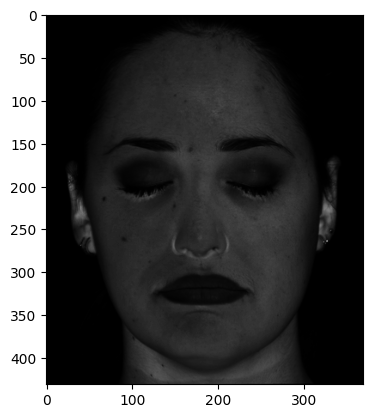

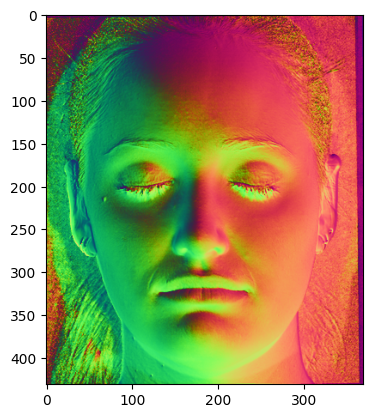

In [57]:
def estimateAlbedosNormals(B):

    '''
    Question 1 (e)

    From the estimated pseudonormals, estimate the albedos and normals

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of estimated pseudonormals

    Returns
    -------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals
    '''

    albedos = None
    normals = None

    ### YOUR CODE HERE
    albedos = np.linalg.norm(B, axis=0)

    eps= 1e-6 #remove zero error

    normals = B / (albedos + eps)
    ### END YOUR CODE

    return albedos, normals


# Part 1(e)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('1f-a.png', albedoIm, cmap = 'gray')
plt.imsave('1f-b.png', normalIm, cmap = 'rainbow')


### Q 1 (f): Normals and depth (5 points)

---

YOUR ANSWER HERE...

---

### Q 1 (g): Understanding integrability of gradients (5 points)

---

YOUR ANSWER HERE...

---

### Q 1 (h): Shape estimation (10 points)

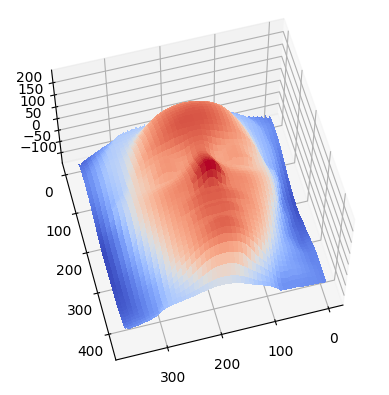

In [58]:
def estimateShape(normals, s):

    """
    Question 1 (h)

    Integrate the estimated normals to get an estimate of the depth map
    of the surface.

    Parameters
    ----------
    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    ----------
    surface: numpy.ndarray
        The image, of size s, of estimated depths at each point

    """

    surface = None

    ### YOUR CODE HERE
    eps = 1e-6
    z_x = np.reshape(normals[0, :]/(-normals[2, :] + eps), s)
    z_y = np.reshape(normals[1, :]/(-normals[2, :] + eps), s)
    surface = integrateFrankot(z_x, z_y)
    ### END YOUR CODE

    return surface


# Part 1(h)
surface = estimateShape(normals, s)
plotSurface(surface)




# Q2: Uncalibrated photometric stereo (50 points)

### Q 2 (a): Uncalibrated normal estimation (10 points)

---

We can apply SVD to matrix I =$USV^T$. We then pick the top three singuar values and zero for the best to get the best rank 3 estimates for $\hat{I}$. We can then set $\hat{L^T}$ to the first three columns of U and  multiply it by the first 3x3 block of S. Then we multiply $\hat{B}$ by the first three rows of $V^T$. THis will result in $\hat{I}=\hat{L^T}\hat{B}$ which has a rank of 3. 

---

### Q 2 (b): Calculation and visualization (10 points)

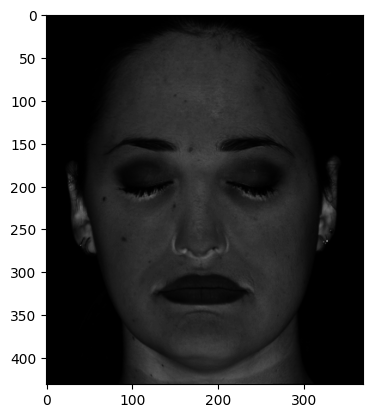

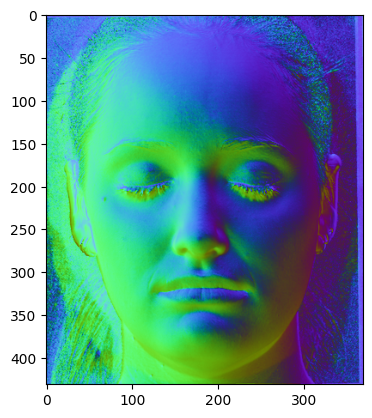

[[-0.33593029  0.26124499  0.61888016  0.59734017 -0.03713893 -0.22129346
   0.16948118]
 [-0.43440914 -0.63866314  0.3341193  -0.36636628 -0.3905672  -0.03771404
   0.05977496]
 [-0.27030342  0.13757076  0.14141256 -0.10130373  0.15406741 -0.03824205
  -0.92333697]]


In [79]:
def estimatePseudonormalsUncalibrated(I):

	"""
	Question 2 (b)

	Estimate pseudonormals without the help of light source directions.

	Parameters
	----------
	I : numpy.ndarray
		The 7 x P matrix of loaded images

	Returns
	-------
	B : numpy.ndarray
		The 3 x P matrix of pesudonormals

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

	"""

	B = None
	L = None
	### YOUR CODE HERE
	u, s, v = np.linalg.svd(I, full_matrices=False)
	s[3:] = 0
   
	B = v[0:3, :]
	L = u[0:3, :]
   
	### END YOUR CODE
	return B, L

# Part 2 (b)
I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('2b-a.png', albedoIm, cmap = 'gray')
plt.imsave('2b-b.png', normalIm, cmap = 'rainbow')

print(LEst	)






### Q 2 (c): Comparing to ground truth lighting

---


$L = \begin{bmatrix}
-0.1418 &  0.1215 & -0.069  &  0.067  & -0.1627 & 0.0    & 0.1478 \\
-0.1804 & -0.2026 & -0.0345 & -0.0402 &  0.122  & 0.1194 & 0.1209 \\
-0.9267 & -0.9717 & -0.838  & -0.9772 & -0.979  & -0.9648 & -0.9713
\end{bmatrix}
$

$\hat{L}= \begin{bmatrix}
-0.33593029 &  0.26124499 &  0.61888016 &  0.59734017 & -0.03713893 & -0.22129346 &  0.16948118 \\
-0.43440914 & -0.63866314 &  0.3341193  & -0.36636628 & -0.3905672  & -0.03771404 &  0.05977496 \\
-0.27030342 &  0.13757076 &  0.14141256 & -0.10130373 &  0.15406741 & -0.03824205 & -0.92333697
\end{bmatrix}
$

They are very different. Normalizing $\hat{L}$ and B,  and multiplying $\hat{B}$ with with matrix G, which has  $\mu$, $\nu$, and $\lambda$ as the last row would change B without changing the rendering. 

---


### Q 2 (d): Reconstructing the shape, attempt 1 (5 points)

---

This does not look like a face. 

---

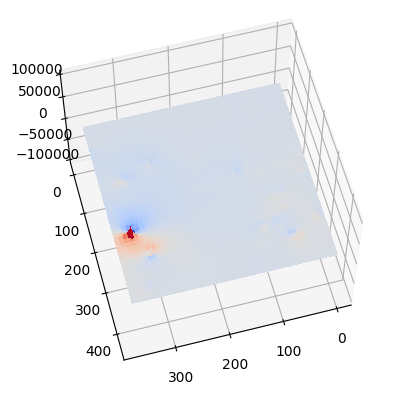

In [60]:
# Part 2 (d)
### YOUR CODE HERE
I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
surface = estimateShape(normals, s)
norm=np.linalg.norm(surface,axis=0)
surfce=surface/norm
plotSurface(surface)
### END YOUR CODE

### Q 2 (e): Reconstructing the shape, attempt 2 (5 points)

---

Yes the image now looks like the output calibrated photometric stereo. 

---


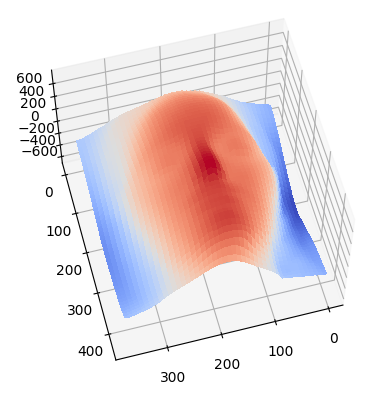

In [61]:
# Part 2 (e)
# Your code here
### YOUR CODE HERE
I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
normals=enforceIntegrability(normals, s, sig = 3)
surface = estimateShape(normals, s)
norm=np.linalg.norm(surface,axis=0)
surfce=surface/norm
plotSurface(surface)
### END YOUR CODE

### Q 2 (f): Why low relief? (5 points)

---

Decreasing $\mu$ stretches the left side of the face and increasing it will stretch the right side of the face.

Decreasing $\nu$ will strech the bottom while increasing will stretch the top. 

If we make $\lambda$ small, it shrinks the scale of the surface and increasing it will increase the scale. 



---

<IPython.core.display.Javascript object>

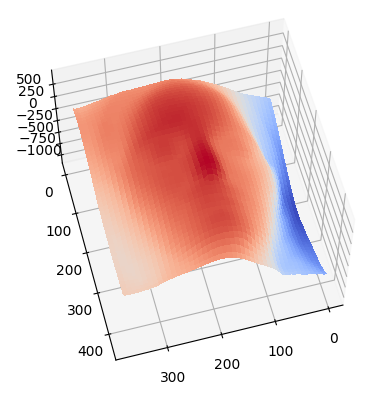

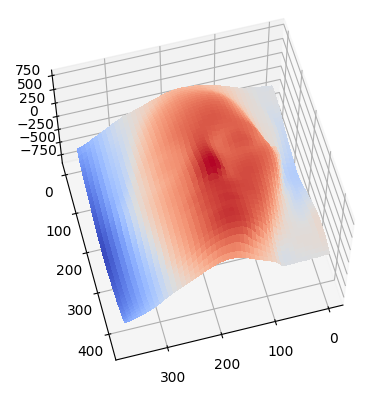

In [62]:
def plotBasRelief(B, mu, nu, lam):

    """
    Question 2 (f)

    Make a 3D plot of of a bas-relief transformation with the given parameters.

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of pseudonormals

    mu : float
        bas-relief parameter

    nu : float
        bas-relief parameter

    lambda : float
        bas-relief parameter

    Returns
    -------
        None

    """
    P = np.asarray([[1, 0, -mu/lam],
					[0, 1, -nu/lam],
					[0, 0,   1/lam]])
    Bp = P.dot(B)
    surface = estimateShape(Bp, s)
    plotSurface(surface, suffix=f'br_{mu}_{nu}_{lam}')

# keep all outputs visible
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Part 2 (f)

### YOUR CODE HERE
I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
normals=enforceIntegrability(normals, s, sig = 3)

plotBasRelief(normals,-10,1,1)
plotBasRelief(normals,10,1,1) #vary mu






### END YOUR CODE



Varying nu

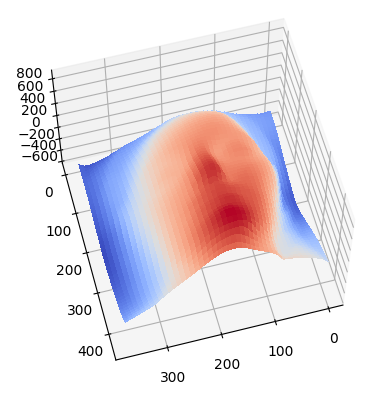

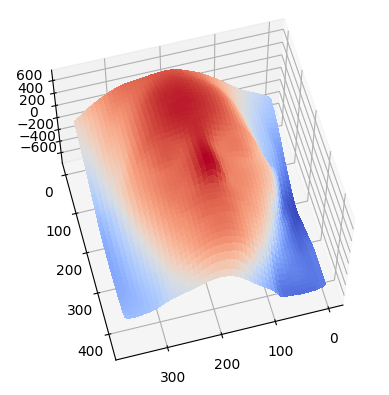

In [47]:
I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
normals=enforceIntegrability(normals, s, sig = 3)
plotBasRelief(normals,1,-10,1)
plotBasRelief(normals,1,10,1) #vary nu



Varying Lambda

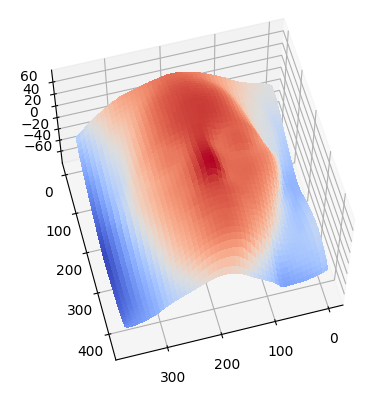

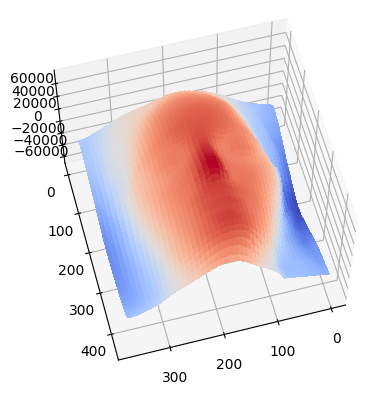

In [65]:

I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
normals=enforceIntegrability(normals, s, sig = 3)
plotBasRelief(normals,1,1,0.1)
plotBasRelief(normals,1,1,100) #vary lambda

### Q 2 (g): Flattest surface possible (5 points)


--- 
I would set up $\mu=0$ and $\nu=0$.  I would also make $\lambda$ as small as possible, but not 0 so that it does not cause a divide by 0 error. By doing so, it would make it so there there is no streching on the sides and a small gradient magnitute for each pixel. 

---

### Q 2 (h): More measurements

---

It will not help resolve the ambiguity as matrix $\hat{I}$ will have a rank=3. This is still the same ambiguity as $\hat{B}$. 

---